In [1]:
import numpy as np
from MTCFeatures import MTCFeatureLoader
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from fractions import Fraction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

### Récupération des données

In [2]:
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
seqs = fl.sequences()

### Récupération des informations des features de chaque séquence.
On les met sous forme de dataframe pandas.

In [3]:
%%time
phrase_data = []
for ii, x in enumerate(seqs):
    phrase_data.append({
        'id': x['id'],
        **x['features']
    })

CPU times: total: 10.5 s
Wall time: 11.5 s


In [4]:
df = pd.DataFrame(phrase_data)

### Définition des modèles
Modèles sur lesquels nous voulons tester l'impact du changement de la taille des sous-séquences.


In [5]:
models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SGDClassifier(),
    LogisticRegression(),
    GaussianNB(),
    RandomForestClassifier(),
]

models_names = [model.__class__.__name__ for model in models]

### Réduction du jeux de données
Pour réaliser ces tests, nous réduisons la taille de notre jeu de données. Nous voulons qu'un quart.


In [6]:
df = df.sample(frac=1/4)

### Création des sous sequences
Taille et step à définir comme on veut.

In [7]:
numerical_columns = [ 'scaledegree', 'imaweigth', 'pitch40', 'midipitch', 'diatonicpitch', 'diatonicinterval', 'chromaticinterval', 'pitchproximity', 'pitchreversal', 'duration', 'onsettick', 'phrasepos', 'phrase_ix', 'songpos', 'IOI', 'IOR', 'beatstrength', 'beat_str', 'beat', 'timesignature', 'gpr2a_Frankland', 'gpr2b_Frankland', 'gpr3a_Frankland', 'gpr3d_Frankland', 'gpr_Frankland_sum', 'lbdm_spitch', 'lbdm_sioi', 'lbdm_srest', 'lbdm_rpitch', 'lbdm_rioi', 'lbdm_rrest', 'lbdm_boundarystrength']

for col in numerical_columns:
    if col in df.columns:
        df[col] = df[col].apply(
        lambda x: [0 if v is None else v for v in x]
    )

### Tailles des sous séquences
Nous allons tester les modèles avec 6 tailles de sous-séquences différentes.



In [8]:
sizes = [2, 4, 6, 8, 10, 12]

### Création des sous sequences
Le décalage est égal à la moitié de a la taille de la séquence.


In [9]:
subseq_l = []

for size in sizes:
    
    step = int(size/2)
    subsequences = []
    labels = []
    ids = []
    list_columns = []
    
    for col in df.columns:
        if col != 'id' and df[col].apply(lambda x: isinstance(x, list)).all():
            list_columns.append(col) #prend les colonnes qui sont composées de liste
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        song_id = row['id']
        sequence_length = len(row['scaledegree'])
    
        if sequence_length == 0:
            continue # Passage à la sequence suivante si ça taille est de 0.
        
        #Parcours de séquences pour créer des sous-séquences.
        start_idx = 0
        while start_idx + size <= sequence_length: 
            end_idx = start_idx + size
    
            subseq = {}
            for col in list_columns:
                subseq[col] = row[col][start_idx:end_idx]
            if len(subseq['scaledegree']) == size:
                label = subseq['phrase_end'][-1] #Utilisation de la dernière valeur de phrase_end, pour labelliser la sous-séquence.
                subsequences.append(subseq)
                labels.append(label)
                ids.append(song_id)
    
            start_idx += step
        
        # Dernière sous séquences.
        if start_idx < sequence_length:
            end_idx = sequence_length
    
            subseq = {}
            for col in list_columns:
                subseq[col] = row[col][start_idx:end_idx]
            if len(subseq['scaledegree']) == size:
                label = subseq['phrase_end'][-1]
                subsequences.append(subseq)
                labels.append(label)
                ids.append(song_id)
    
    subsequences = pd.DataFrame(subsequences)
    subsequences['id'] = ids
    subsequences['label'] = labels
    
    subseq_l.append(subsequences)

100%|██████████| 4527/4527 [00:08<00:00, 524.75it/s]


### Choix des features à utiliser
Sélection des features, puis on étend les listes de sous-séquences. 

In [10]:
feature_columns = ["duration", "beatinphrase", 'restduration_frac', "beatinphrase_end", "beatstrength", "gpr2b_Frankland", "gpr_Frankland_sum", "lbdm_srest", "lbdm_boundarystrength", "pitch40", 'imaweight']

features_list = []
for subsequences in subseq_l:
    feature_arrays = []
    for idx, row in tqdm(subsequences.iterrows(), total=subsequences.shape[0], desc="Processing subsequences"):
        feature_vector = []
        for col in feature_columns:
            feature_vector.extend(row[col]) #on étend les sequences.
        feature_arrays.append(feature_vector)
    
    features = np.array(feature_arrays)
    labels = np.array(subsequences['label'])
    ids = np.array(subsequences['id'])
    
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    features_list.append((features, labels))

Processing subsequences: 100%|██████████| 47042/47042 [00:02<00:00, 19593.03it/s]


### Formatage des données
Transformation des fractions en valeur numérique, transformation des données catégorielles et normalisation.


In [11]:
final_features_l = []
for features, labels in features_list:
    for x in range(features.shape[1]):
        features[:, x] = [
            float(Fraction(value)) if isinstance(value, str) and '/' in value else
            float(value) if value is not None else 0.0  # Remplacement des None par 0.0
            for value in features[:, x]
        ]
            
    cat_columns = [] #index des colones catégorielles
    num_columns = [] #index des colones numériques a normaliser
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse_output=False), cat_columns),  # Encodage catégoriel
            ('num', StandardScaler(), num_columns)  # Normalisation 
        ],
        remainder='passthrough' #données non modifiées
    )
    
    final_features = preprocessor.fit_transform(features)
    final_features_l.append((final_features, labels))

### Entrainement des modeles
Utilisation de cross_val_score pour entraîner nos modèles et récupérer leurs scores.


In [14]:
scores_per_size = {name: [] for name in models_names}

for subsample in final_features_l:
    X_subsample, y_subsample = subsample

    for method, name in zip(models, models_names):
        scores = cross_val_score(method, X_subsample, y_subsample, cv=5) # 5 plis pour la validation croisée
        scores_per_size[name].append(scores)

C:\Users\val92\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\val92\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### visualisation des résultats
Graphique montrant l'évolution des scores moyens en fonction de la taille des sous-séquences.

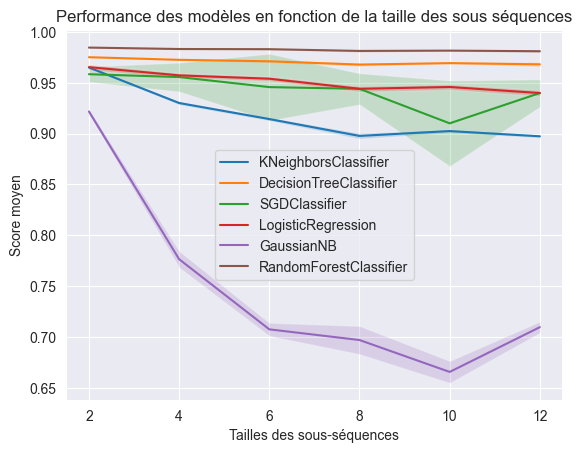

In [15]:
for model in models_names :
    model_results = scores_per_size[model]
    means = [np.mean(scores) for scores in model_results]
    stds = [np.std(scores) for scores in model_results]
    
    plt.plot(sizes, means, label=model)
    
    plt.fill_between(sizes, 
                     np.array(means) - np.array(stds), 
                     np.array(means) + np.array(stds), alpha=0.2)

plt.title("Performance des modèles en fonction de la taille des sous séquences")
plt.xlabel("Tailles des sous-séquences")
plt.ylabel("Score moyen")
plt.legend()
plt.show()